EC 48E Assignment 3

----

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [ ]:
gdp_data = pd.read_csv("/content/gdp_data.csv", sep=";")

## Question 1

### a

In [ ]:
gdp = gdp_data["income"]
X = sm.add_constant(np.log(gdp_data[["labor", "capital"]]))
gdp_model = sm.OLS(gdp, X).fit()
gdp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     971.4
Date:                Sat, 22 Jun 2024   Prob (F-statistic):           2.99e-18
Time:                        21:09:14   Log-Likelihood:                -206.83
No. Observations:                  20   AIC:                             419.7
Df Residuals:                      17   BIC:                             422.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.518e+06   1.76e+05    -14.271      0.000   -2.89e+06   -2.15e+06
labor       2.249e+05   2.71e+04      8.285      0.000    1.68e+05    2.82e+05
capital    -1.208e+04   5.41e+04     -0.223      0.826   -1.26e+05    1.02e+05
==============================================================================
Omnibus:                        3.467   Durbin-Watson:                   0.295
Prob(Omnibus):                  0.177   Jarque-Bera (JB):                2.658
Skew:                           0.880   Prob(JB):                        0.265
Kurtosis:                       2.700   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# assume that these are true population parameters
b0,b1,b2 = gdp_model.params
sigma2 = (sum((gdp_model.resid)**2))/17
se_betas = gdp_model.bse
print("true betas:")
print(round(gdp_model.params,2))
print("---------------------")
print(f"variance(sigma^2): {sigma2}")
print("---------------------")
print("std. errors of betas:")
print(gdp_model.bse)

true betas:
const     -2518131.66
labor       224870.81
capital     -12080.71
dtype: float64
---------------------
variance(sigma^2): 66151633.289513156
---------------------
std. errors of betas:
const      176448.402971
labor       27140.304052
capital     54060.007454
dtype: float64


### b

In [ ]:
# here is actual vs fitted values table
gdp_fit = gdp_model.predict(X)
act_vs_fit = pd.concat([gdp_data[["date","income"]],gdp_fit], axis=1).rename(columns={"income": "actual", 0:"fitted"})
act_vs_fit.round()

,date,actual,fitted
0,1955,114043,96559.0
1,1956,120410,110172.0
2,1957,129187,122783.0
3,1958,134705,133127.0
4,1959,139960,142943.0
5,1960,150511,154118.0
6,1961,157897,165160.0
7,1962,165286,175375.0
8,1963,178491,186985.0
9,1964,199457,201946.0


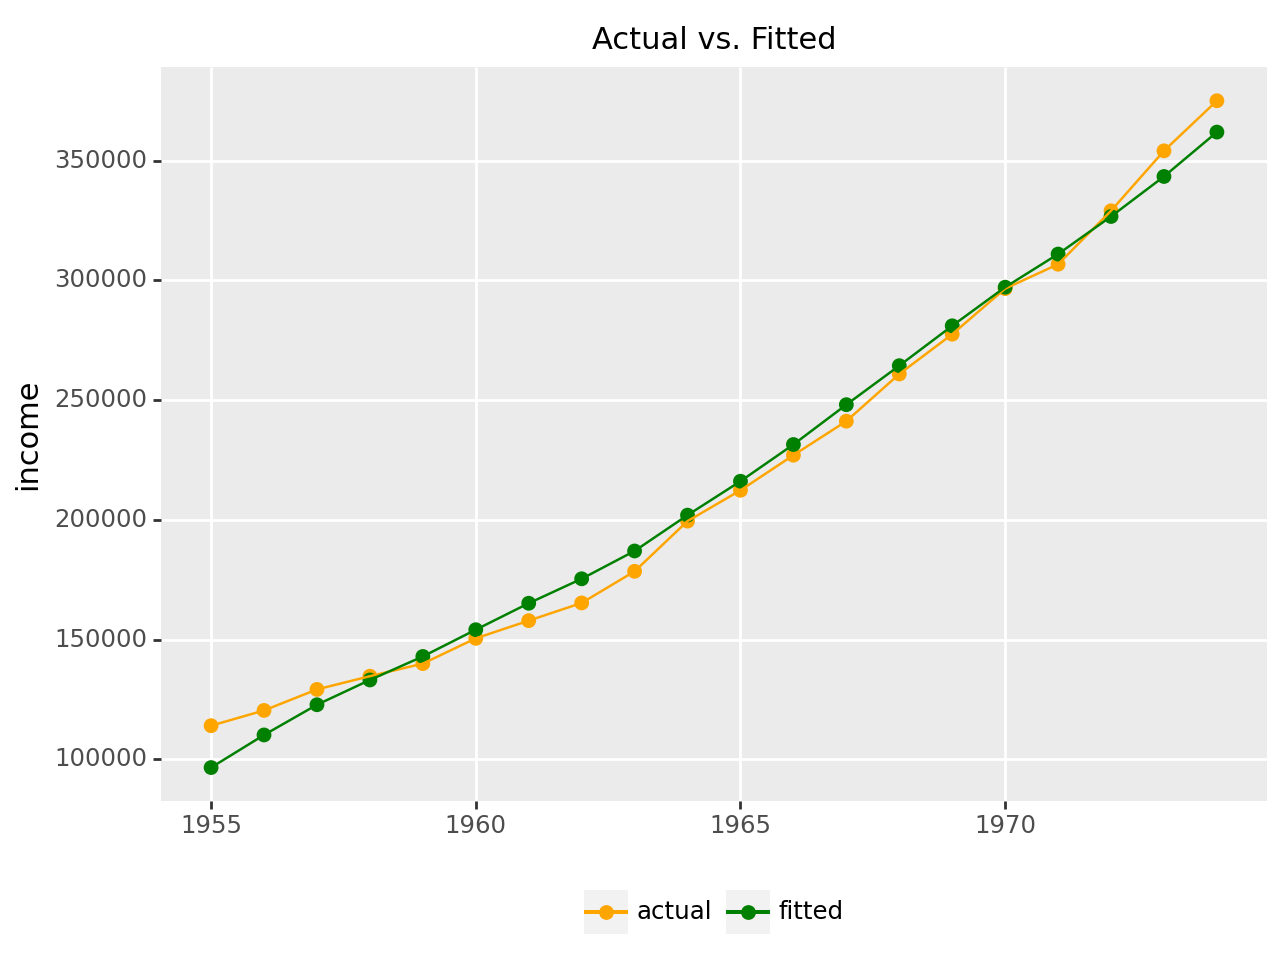

<Figure Size: (640 x 480)>

In [ ]:
act_fit_melted = pd.melt(act_vs_fit, id_vars="date", value_vars=["actual","fitted"], value_name="income")

(ggplot(act_fit_melted,aes("date", "income", color="variable")) +
 geom_point(size=2) +
 geom_line() +
 labs(subtitle="Actual vs. Fitted", x="") +
 theme(legend_title=element_blank(), legend_position="bottom",
       panel_grid_minor=element_blank(),
       plot_subtitle=element_text(hjust=.5)) +
 scale_y_continuous(breaks=np.arange(100_000,350_001,50_000)) +
 scale_color_manual(["orange", "green"])
)

In [ ]:
print(f"The model's R^2 is: {gdp_model.rsquared.round(3)}")
print(f"The model's adj. R^2 is: {gdp_model.rsquared_adj.round(3)}")

The model's R^2 is: 0.991
The model's adj. R^2 is: 0.99


The model's R-squared values seem splendid, but as William Shakespeare said "All that glitters is not gold". These high R-squared levels raise suspicion, and so we might want to look at some graphs and check the assumption whether they are violated.

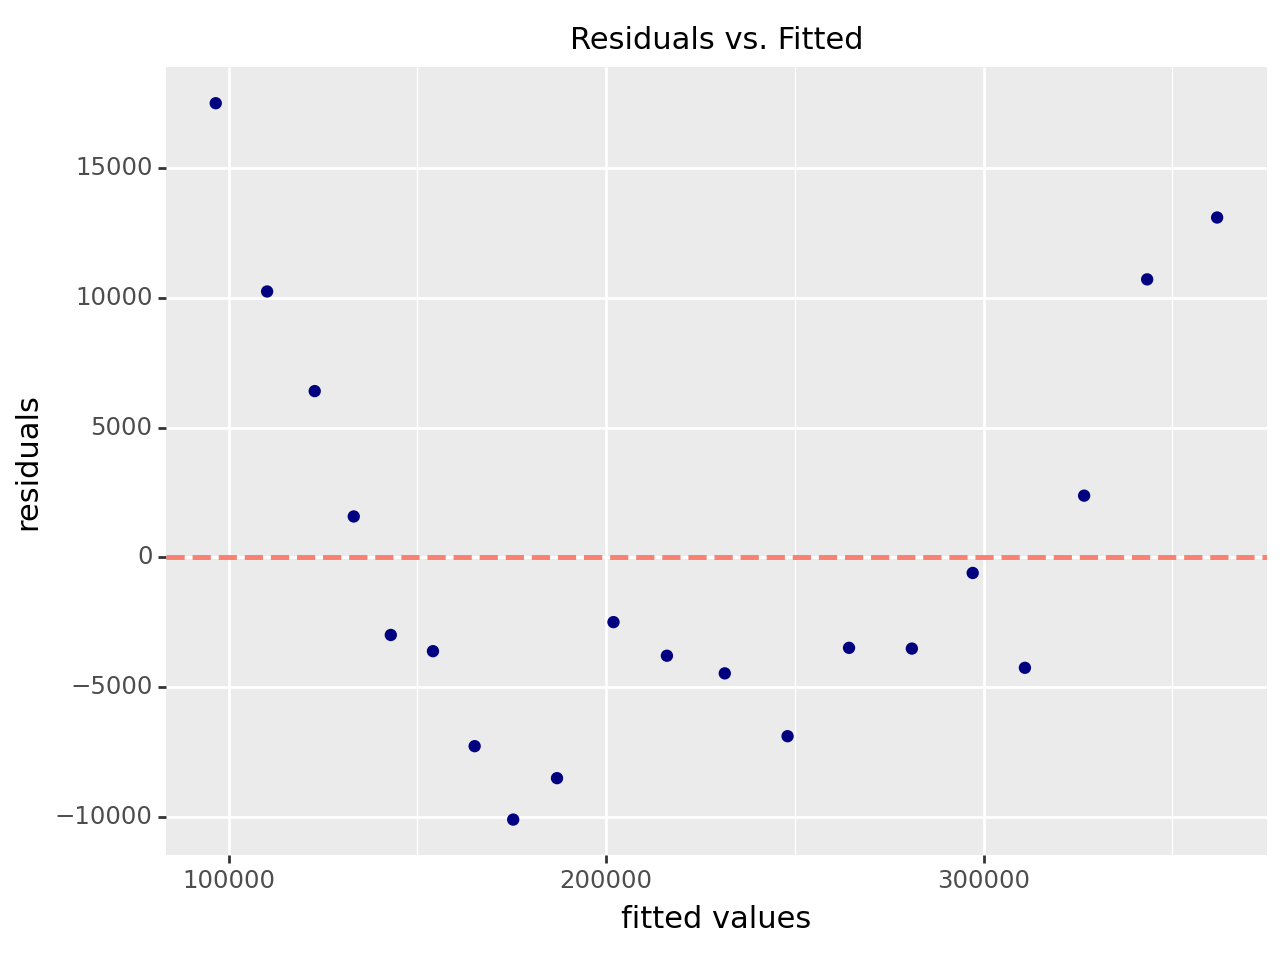

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(aes(gdp_fit, gdp_model.resid)) +
 geom_point(color = "navy") +
 geom_hline(yintercept=0, size=1, linetype="dashed", color = "salmon") +
 labs(subtitle="Residuals vs. Fitted", x="fitted values", y="residuals") +
 theme(plot_subtitle=element_text(hjust=.5),
       panel_grid_minor_y=element_blank()) +
 scale_y_continuous(breaks=np.arange(-10_000,15_001,5_000))
)

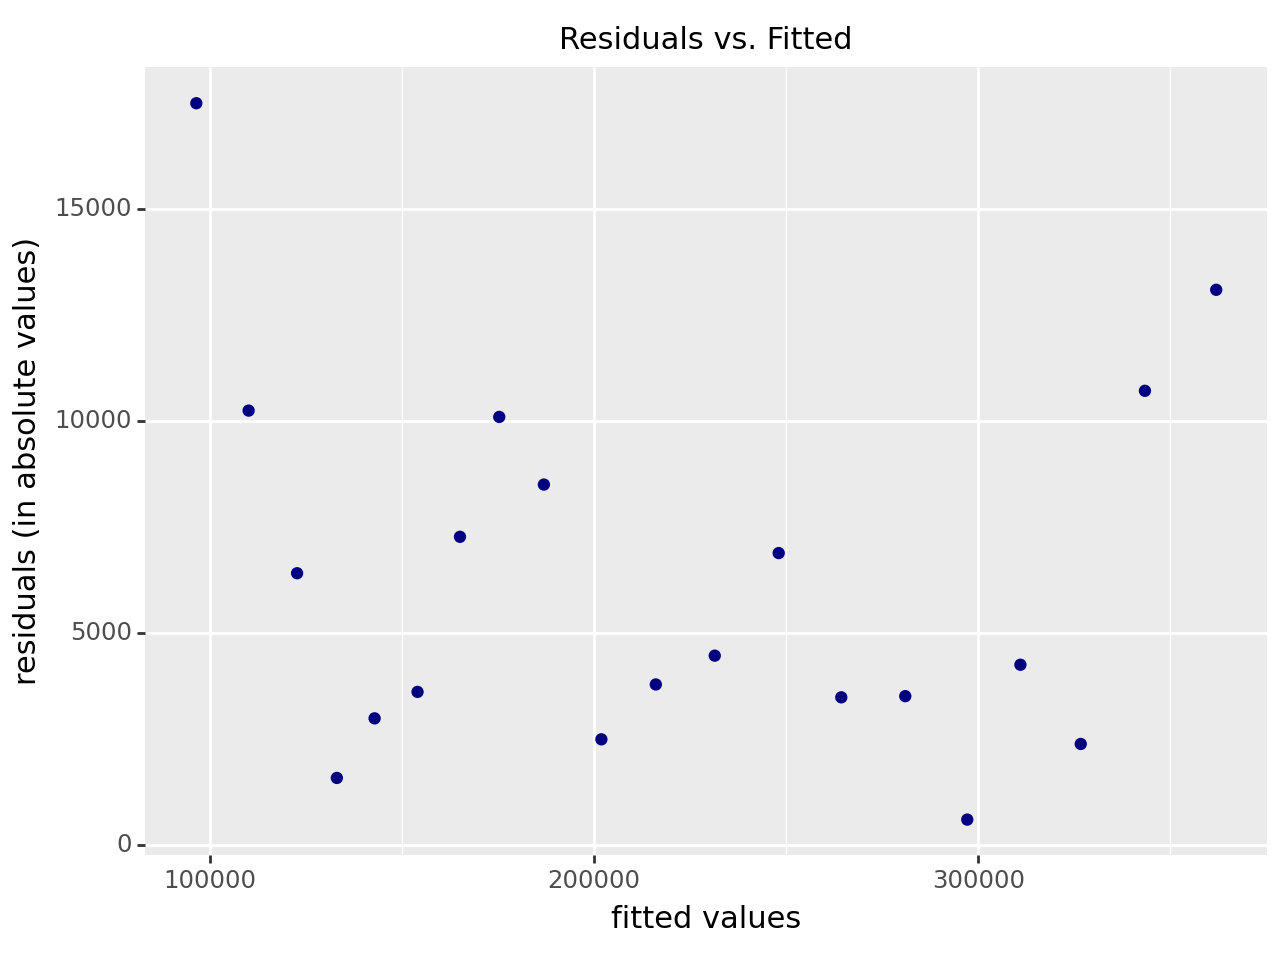

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(aes(gdp_fit, np.abs(gdp_model.resid))) +
 geom_point(color = "navy") +
 labs(subtitle="Residuals vs. Fitted", x="fitted values", y="residuals (in absolute values)") +
 theme(plot_subtitle=element_text(hjust=.5),
       panel_grid_minor_y=element_blank())
)

Let's start with residuals vs. fitted graph. The expectation is residuals have no pattern on fitted values (no jump on variances as X grows). However, for lower and higher levels of fitted values, residuals tend to be higher. We can perform Breusch-Pagan test for heteroskedasticity.

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(gdp_model.resid, gdp_model.model.exog)

(0.8396386008068091,
 0.6571655586380474,
 0.3724840026847513,
 0.6945067263566975)

According to Breusch-Pagan test results, there is not enough proof to say that heteroscedasticity is present. (p value is 0.65)

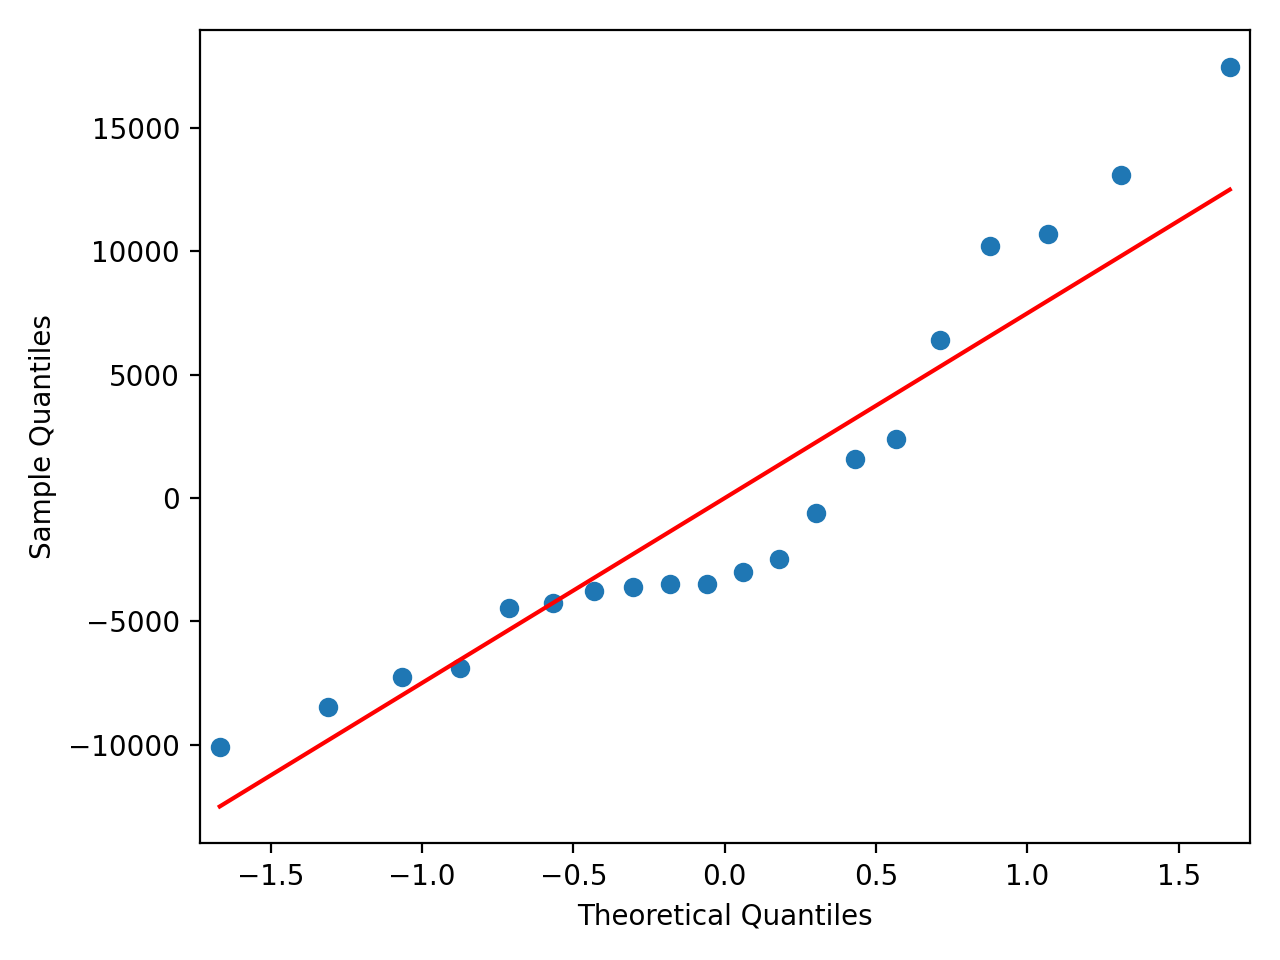

In [ ]:
sm.qqplot(gdp_model.resid, line="s")
plt.tight_layout()

This QQ plot suggests that residuals may not be normally distributed (and could be skewed). It's better to conduct a normality test on residuals. I used Shapiro-Wilk test for normality.

In [ ]:
from scipy.stats import shapiro
shapiro(gdp_model.resid)

ShapiroResult(statistic=0.8924558758735657, pvalue=0.029845723882317543)

The statistical interpretation of this test may depend on the threshold we choose, but what we can say is that we have reasonable doubt that residuals are not normally distributed. Moreover, with 0.05 significance level we have sufficient evidence to say that residuals don't come from a normal distribution, which is problematic because it means a violation of one of the key OLS assumptions.

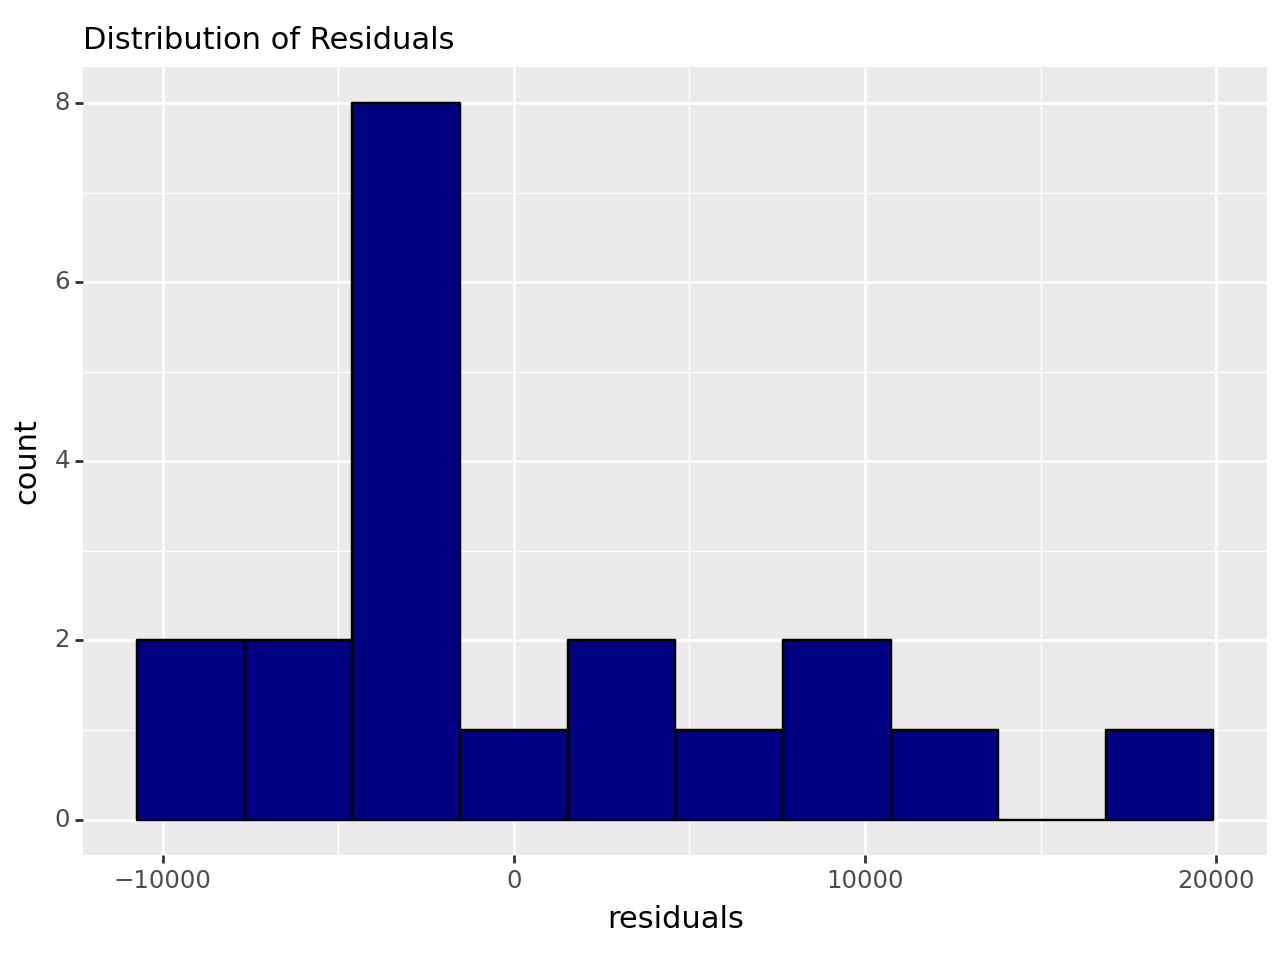

<Figure Size: (640 x 480)>

In [ ]:
(ggplot() +
 geom_histogram(aes(gdp_model.resid), bins=10, color="black", fill="navy") +
 labs(subtitle="Distribution of Residuals", x="residuals")
 )

We can say that distribution of residuals is centered around some value below 0 with positive (right) skewness. (centered at 0  with no skewness is expected)

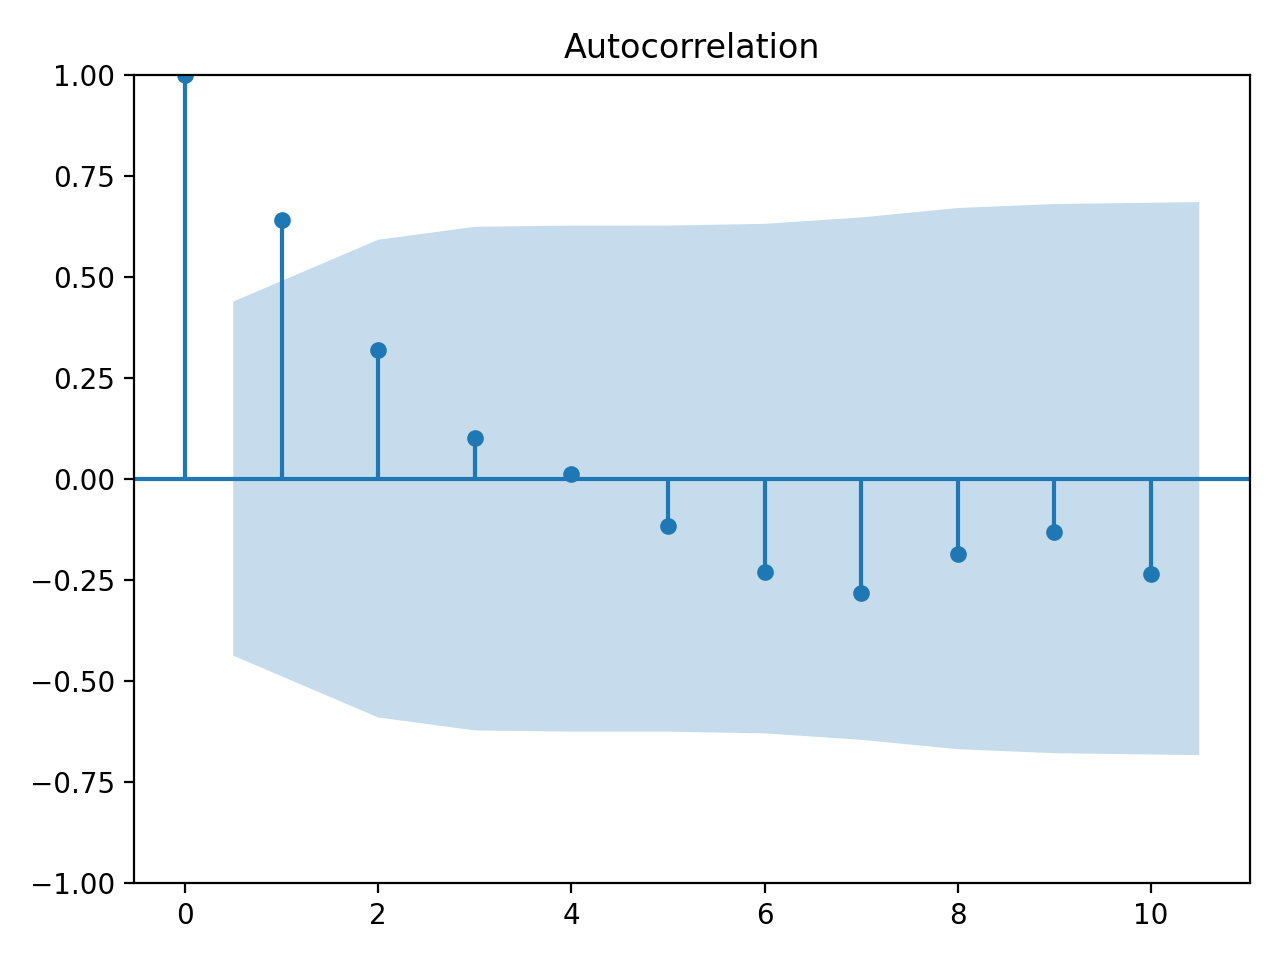

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(gdp_model.resid)
plt.tight_layout()

The ugly graph above reveals yet another important information: Residuals seems to be serially correlated.

### c - d

In order to save time, I will also run Monte Carlo simulation for average residuals and R-squared scores in advance. Though, it still takes some time.

In [ ]:
# prep to Monte Carlo trials
MC = 100_000          # number of trials
N = len(X)            # number of obs
dof = len(X.columns)  # degree of freedom
sigma2 = (sum((gdp-gdp_fit)**2))/(N-dof)
sdu = np.sqrt(sigma2)

# creating empty arrays for random y's and parameters
y_vec = np.full((MC, N),np.nan)
beta0 = np.full(MC,np.nan)
beta1 = np.full(MC,np.nan)
beta2 = np.full(MC,np.nan)
avg_resid = np.full(MC, np.nan)
r2 = np.full(MC,np.nan)
r2_adj = np.full(MC,np.nan)

In [ ]:
# running Monte Carlo simulations
# first for Gaussian error terms
np.random.seed(1)
for mc in range(MC):
  # generating u~N(0,(sdu)^2)
  u_normal = np.random.normal(size=N) * sdu
  # recreating y by using true population params and gaussian error terms
  y_temp = b0 + b1*X["labor"] + b2*X["capital"] + u_normal
  y_vec[mc, :] = y_temp
  # fitting the model and obtaining estimates
  fit_temp = sm.OLS(y_temp, X).fit()
  beta0[mc], beta1[mc], beta2[mc] = fit_temp.params
  avg_resid[mc] = np.mean(fit_temp.resid)
  r2[mc] = fit_temp.rsquared
  r2_adj[mc] = fit_temp.rsquared_adj

# and then for t-distributed errors with selected nu's
nu = [5,10,20,25,100]

beta0_dist=pd.DataFrame()
beta1_dist=pd.DataFrame()
beta2_dist=pd.DataFrame()
avg_resid_dist=pd.DataFrame()
r2_dist=pd.DataFrame()
r2_adj_dist=pd.DataFrame()

# storing the results from normally distributed errors case
beta0_dist = pd.concat([beta0_dist,pd.Series(beta0)],axis=1)
beta1_dist = pd.concat([beta1_dist,pd.Series(beta1)],axis=1)
beta2_dist = pd.concat([beta2_dist,pd.Series(beta2)],axis=1)
avg_resid_dist =pd.concat([avg_resid_dist,pd.Series(avg_resid)],axis=1)
r2_dist = pd.concat([r2_dist,pd.Series(r2)],axis=1)
r2_adj_dist = pd.concat([r2_adj_dist,pd.Series(r2_adj)],axis=1)

# MC trials for different degrees of freedom
for v in nu:
  np.random.seed(1)
  for mc in range(MC):
    u_t = t.rvs(v, size=N) * sdu
    y_temp = b0 + b1*X["labor"] + b2*X["capital"] + u_t
    y_vec[mc, :] = y_temp
    # fitting the model and obtaining estimates
    fit_temp = sm.OLS(y_temp, X).fit()
    beta0[mc], beta1[mc], beta2[mc] = fit_temp.params
    avg_resid[mc] = np.mean(fit_temp.resid)
    r2[mc] = fit_temp.rsquared
    r2_adj[mc] = fit_temp.rsquared_adj
  beta0_dist = pd.concat([beta0_dist,pd.Series(beta0)],axis=1)
  beta1_dist = pd.concat([beta1_dist,pd.Series(beta1)],axis=1)
  beta2_dist = pd.concat([beta2_dist,pd.Series(beta2)],axis=1)
  avg_resid_dist =pd.concat([avg_resid_dist,pd.Series(avg_resid)],axis=1)
  r2_dist = pd.concat([r2_dist,pd.Series(r2)],axis=1)
  r2_adj_dist = pd.concat([r2_adj_dist,pd.Series(r2_adj)],axis=1)

# finally, renaming column names
col_names=["normal","t(5)","t(10)","t(20)","t(25)","t(100)"]
beta0_dist.columns = col_names
beta1_dist.columns = col_names
beta2_dist.columns = col_names
avg_resid_dist.columns = col_names
r2_dist.columns = col_names
r2_adj_dist.columns = col_names

Let's compare β's from Monte Carlo sim with true population parameters.

In [ ]:
betas_norm=pd.DataFrame({
    "beta_0": beta0_dist["normal"],
    "beta_1": beta1_dist["normal"],
    "beta_2": beta2_dist["normal"]
})

print("Monte Carlo average of betas:")
print(betas_norm.agg(np.mean).round(2))
print("-----------------------------")
print("difference between true params and average of MC params:")
betas_norm.agg(np.mean) - [b0,b1,b2]

Monte Carlo average of betas:
beta_0   -2518928.13
beta_1     224691.11
beta_2     -11750.51
dtype: float64
-----------------------------
difference between true params and average of MC params:


beta_0   -796.473908
beta_1   -179.701588
beta_2    330.194736
dtype: float64

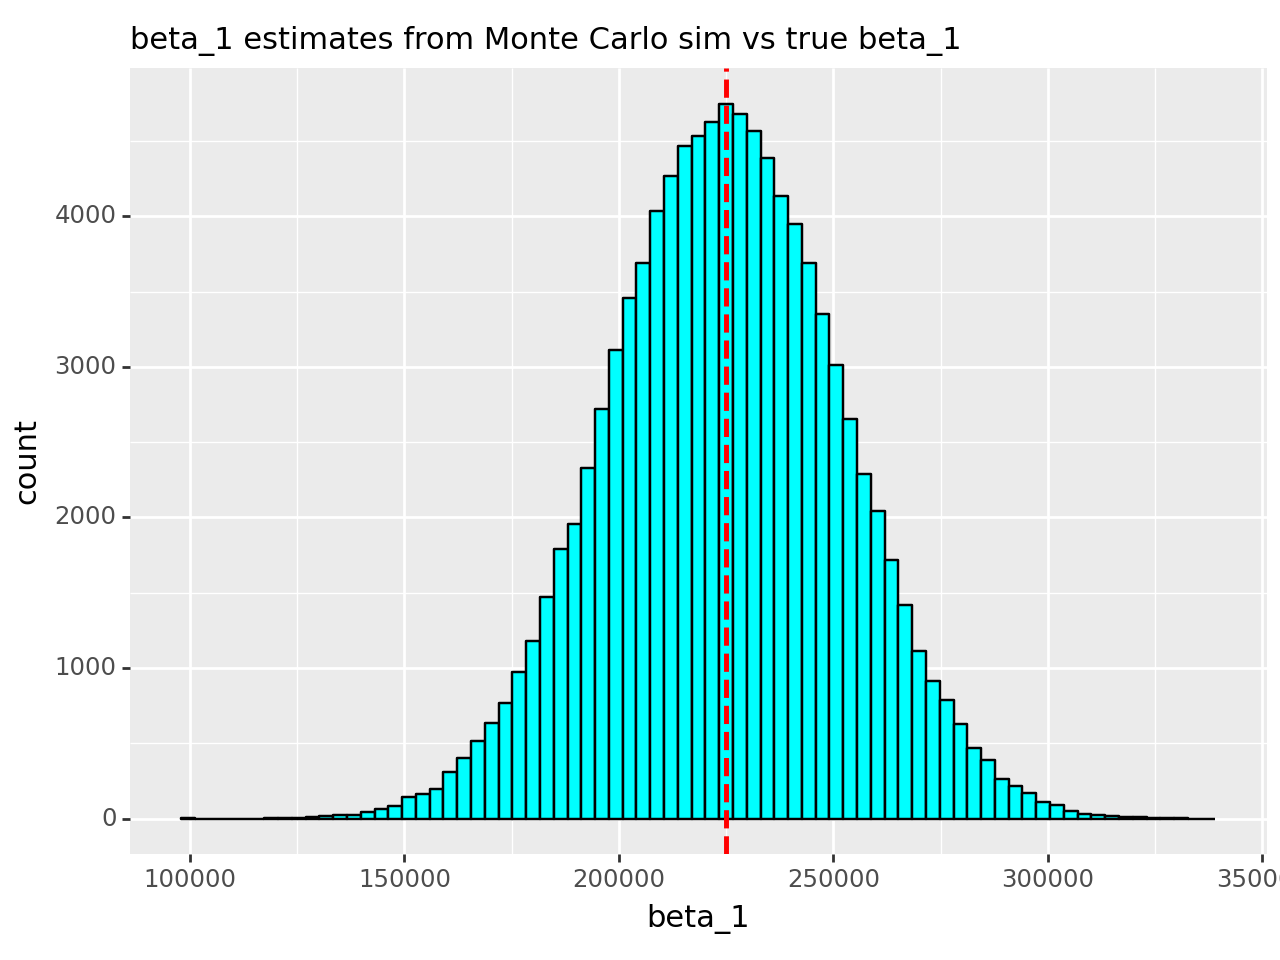

<Figure Size: (640 x 480)>

In [ ]:
(ggplot() +
 geom_histogram(betas_norm, aes(x="beta_1"), color="black", fill="cyan", bins=75) +
 geom_vline(xintercept=b1, linetype="dashed", color="red", size=1) +
 labs(subtitle="beta_1 estimates from Monte Carlo sim vs true beta_1"))

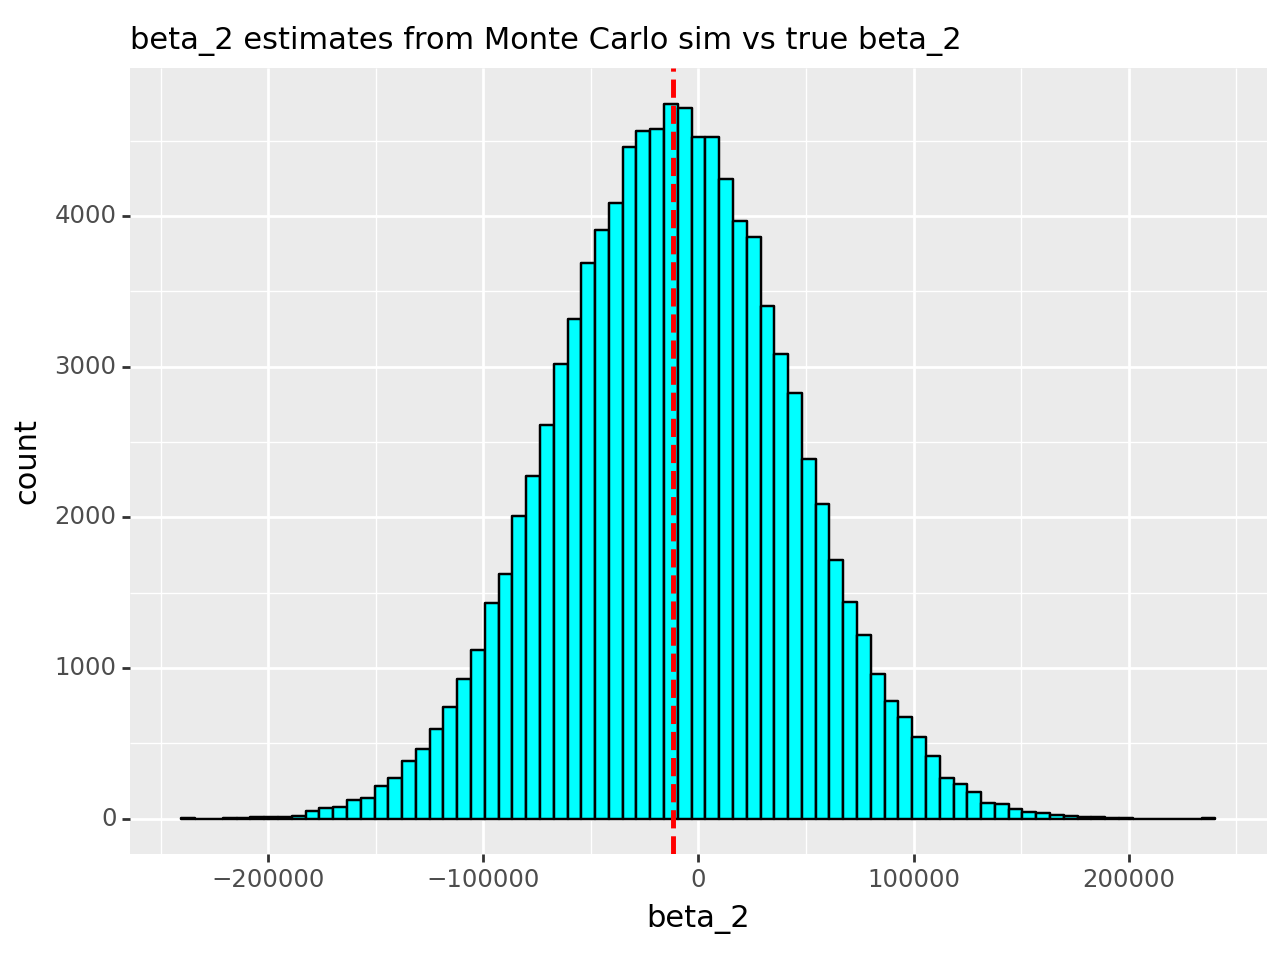

<Figure Size: (640 x 480)>

In [ ]:
(ggplot() +
 geom_histogram(betas_norm, aes(x="beta_2"), color="black", fill="cyan", bins=75) +
 geom_vline(xintercept=b2, linetype="dashed", color="red", size=1) +
 labs(subtitle="beta_2 estimates from Monte Carlo sim vs true beta_2"))

As we expected, the betas are normally distributed and centered around true population parameters.

### e

First, let's compare the average of betas under different cases.

In [ ]:
print(f"We assume that true beta_1 is {round(b1)}")
print("average beta for different distributions:")
print(beta1_dist.agg(np.mean).round())
print("--------------------")
print(f"We assume that true beta_2 is {round(b2)}")
print("average beta for different distributions:")
beta2_dist.agg(np.mean).round()

We assume that true beta_1 is 224871
average beta for different distributions:
normal    224691.0
t(5)      225004.0
t(10)     224972.0
t(20)     224852.0
t(25)     224881.0
t(100)    224762.0
dtype: float64
--------------------
We assume that true beta_2 is -12081
average beta for different distributions:


normal   -11751.0
t(5)     -12348.0
t(10)    -12243.0
t(20)    -12090.0
t(25)    -12065.0
t(100)   -11848.0
dtype: float64

t-distribution with 20 and 25 degrees of freedom provide closer estimates. Note that the models degree of freedom is 17.

Then, take a quick look at distributions.

In [ ]:
beta1_long = beta1_dist.melt(var_name="dist", value_name="beta_1")
beta2_long = beta2_dist.melt(var_name="dist", value_name="beta_2")

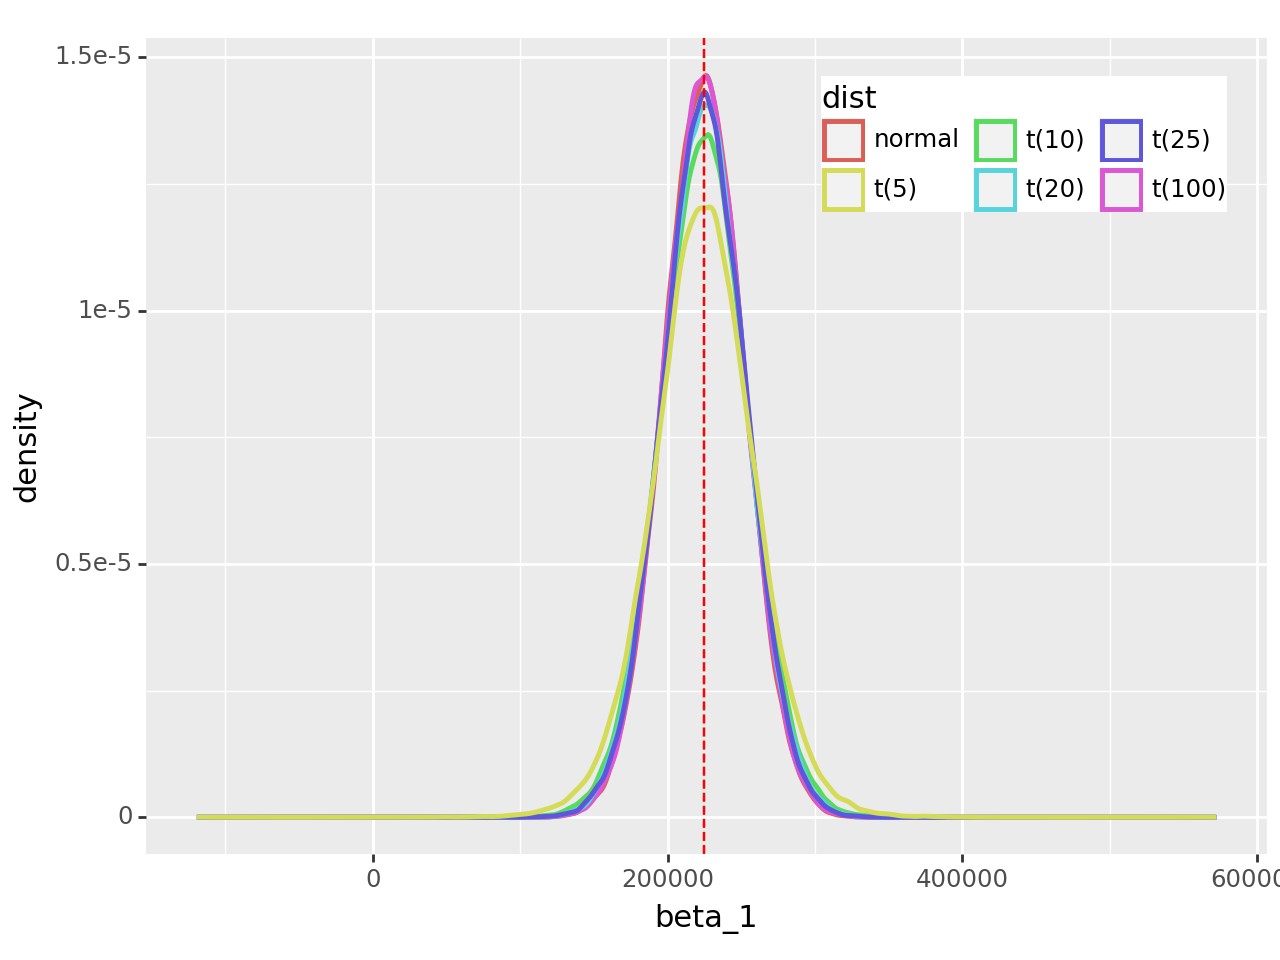

<Figure Size: (640 x 480)>

In [ ]:
(ggplot() +
 geom_density(beta1_long,aes("beta_1", color="dist"),size=1) +
 theme(legend_position=(.8,.85)) +
 scale_color_discrete(limits=col_names) +
 geom_vline(xintercept=b1, linetype="dashed", color="red")
 )

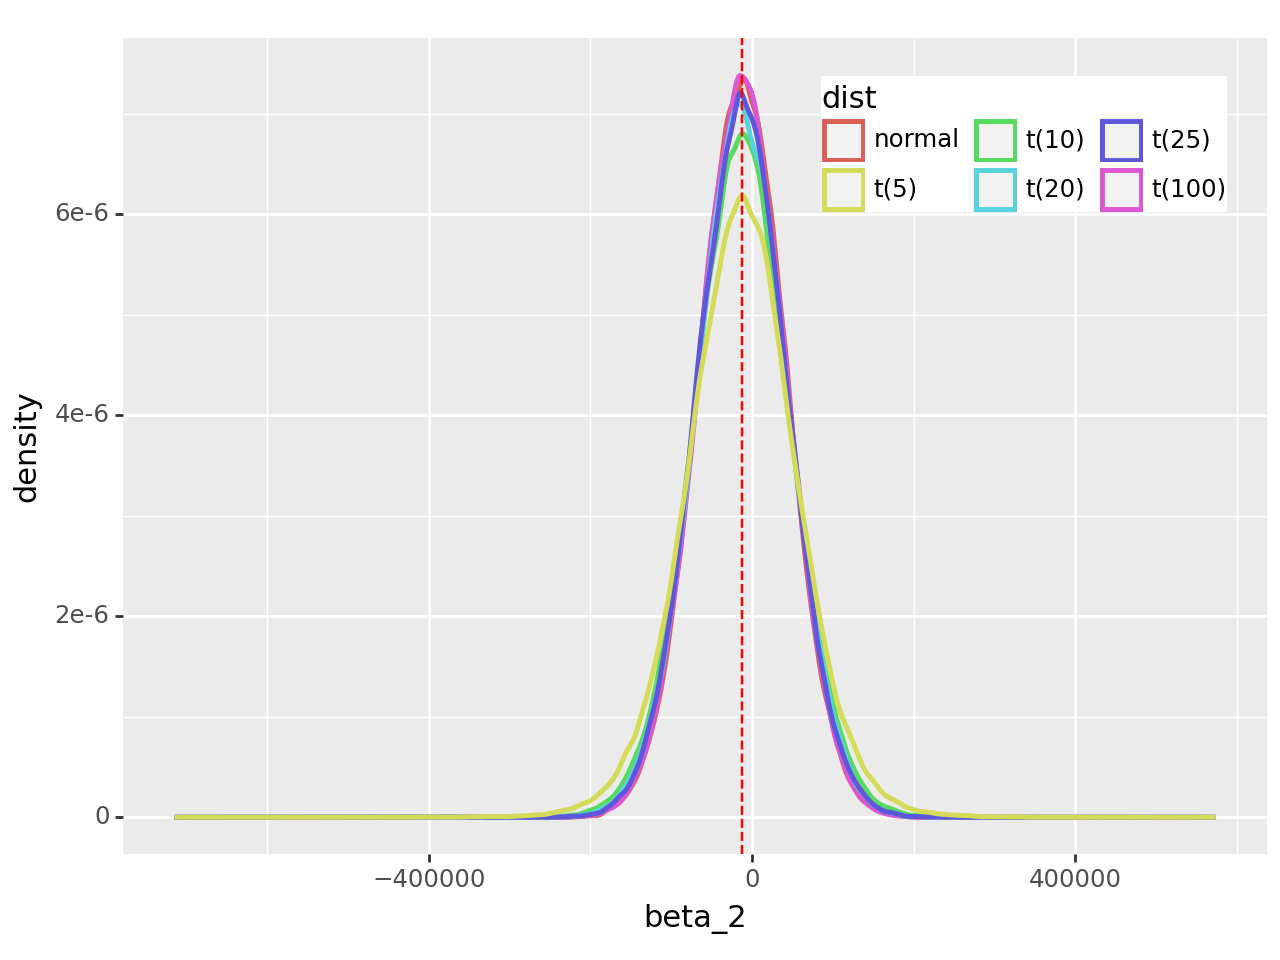

<Figure Size: (640 x 480)>

In [ ]:
(ggplot() +
 geom_density(beta2_long,aes("beta_2", color="dist"),size=1) +
 theme(legend_position=(.8,.85)) +
 scale_color_discrete(limits=col_names) +
 geom_vline(xintercept=b2, linetype="dashed", color="red")
 )

It is clearly seen that as degree of freedom decreases, we get fatter tailed distributions (greater possibility of seeing extreme values) and as degree of freedom increases, our estimates for β's hence confidence interval is getting narrower and narrower. Note that, as degree of freedom gets higher, the shape of distribution gets close to the normal.

### f

In [ ]:
# we can calculate variance and std errors of betas manually
var_betas = sigma2*np.diag(np.linalg.inv(X.T @ X))
print("variance of betas:")
for i in range(len(var_betas)):
  print(var_betas[i])
print("-----------------")
print("se of betas:")
for i in range(len(var_betas)):
  print(np.sqrt(var_betas[i]))

variance of betas:
31134038911.685383
736596104.0660948
2922484405.979019
-----------------
se of betas:
176448.40297289568
27140.304052572712
54060.00745448542


In [ ]:
# or alternatively we can directly extract them from OLS results
gdp_model.bse

const      176448.402971
labor       27140.304052
capital     54060.007454
dtype: float64

### g

In [ ]:
print(f"parametric SE(beta_1) is {round(gdp_model.bse[1])}")
print("SE(beta_1) for different distributions:")
print(np.std(beta1_dist, ddof=1).round())
print("--------------------")
print(f"parametric SE(beta_2) is {round(gdp_model.bse[2])}")
print("SE(beta_2) for different distributions:")
np.std(beta2_dist, ddof=1).round()

parametric SE(beta_1) is 27140
SE(beta_1) for different distributions:
normal    27151.0
t(5)      34904.0
t(10)     30191.0
t(20)     28665.0
t(25)     28360.0
t(100)    27322.0
dtype: float64
--------------------
parametric SE(beta_2) is 54060
SE(beta_2) for different distributions:


normal    54098.0
t(5)      69477.0
t(10)     60153.0
t(20)     57128.0
t(25)     56457.0
t(100)    54429.0
dtype: float64

Normal distribution has more precision on estimation var(β)'s. As we see in beta distribution graph above, the higher the degree of freedom the less dispersion (spread) over β's.

### h

In [ ]:
# theoric CIs
CI = [0.005,0.025,0.975,0.995]
tstat = t.ppf(CI, df=17)
b1_ci = pd.DataFrame(b1+tstat*gdp_model.bse[1]).T
b2_ci = pd.DataFrame(b2+tstat*gdp_model.bse[2]).T

In [ ]:
# confidence intervals from Monte Carlo
ci1 = pd.DataFrame([np.quantile(beta1_dist[col], CI) for col in beta1_dist.columns])
ci2 = pd.DataFrame([np.quantile(beta2_dist[col], CI) for col in beta2_dist.columns])

In [ ]:
ii = ["parametric", "normal", "t(5)", "t(10)", "t(20)", "t(25)", "t(100)"]

In [ ]:
conf_int1=pd.concat([b1_ci,ci1]).rename(columns={0:"0.005",1:"0.025",2:"0.975",3:"0.995"})
conf_int2=pd.concat([b2_ci,ci2]).rename(columns={0:"0.005",1:"0.025",2:"0.975",3:"0.995"})
conf_int1.index=ii
conf_int2.index=ii
conf_int1

,0.005,0.025,0.975,0.995
parametric,146211.956246,167609.777486,282131.850040,303529.671280
normal,154051.296810,171296.172948,278023.690668,294523.828053
t(5),128233.329082,156280.871920,294051.195067,321996.565372
t(10),144728.974886,165565.041426,284191.070012,304380.085753
t(20),151212.083974,168558.880790,281619.616567,299710.721278
t(25),150645.834864,168959.784106,280321.133893,298243.467743
t(100),154411.896835,171371.307235,278473.669521,295643.308808


In [ ]:
conf_int2

,0.005,0.025,0.975,0.995
parametric,-168759.068737,-126137.351106,101975.940622,144597.658253
normal,-151294.105614,-117956.105644,94840.247675,128019.473503
t(5),-206532.695998,-150477.985809,124956.472050,180976.198753
t(10),-171871.330036,-131120.873601,106812.161100,147002.863214
t(20),-161509.831703,-124948.076634,100412.152738,135657.613905
t(25),-158353.130077,-122924.155558,99350.795584,135948.110176
t(100),-152691.360863,-118980.121072,94779.508703,127864.932533


The parametric confidence interval differs from Monte Carlo simulation confidence interval. In previous parts, we see that some assumptions may be violated so error term not normally distributed. t(20) provides the closest intervals. (degree of freedom of residuals was 17.)

### i

In [ ]:
resid_df = avg_resid_dist[["normal","t(5)"]].melt(var_name="dist", value_name="avg resid")

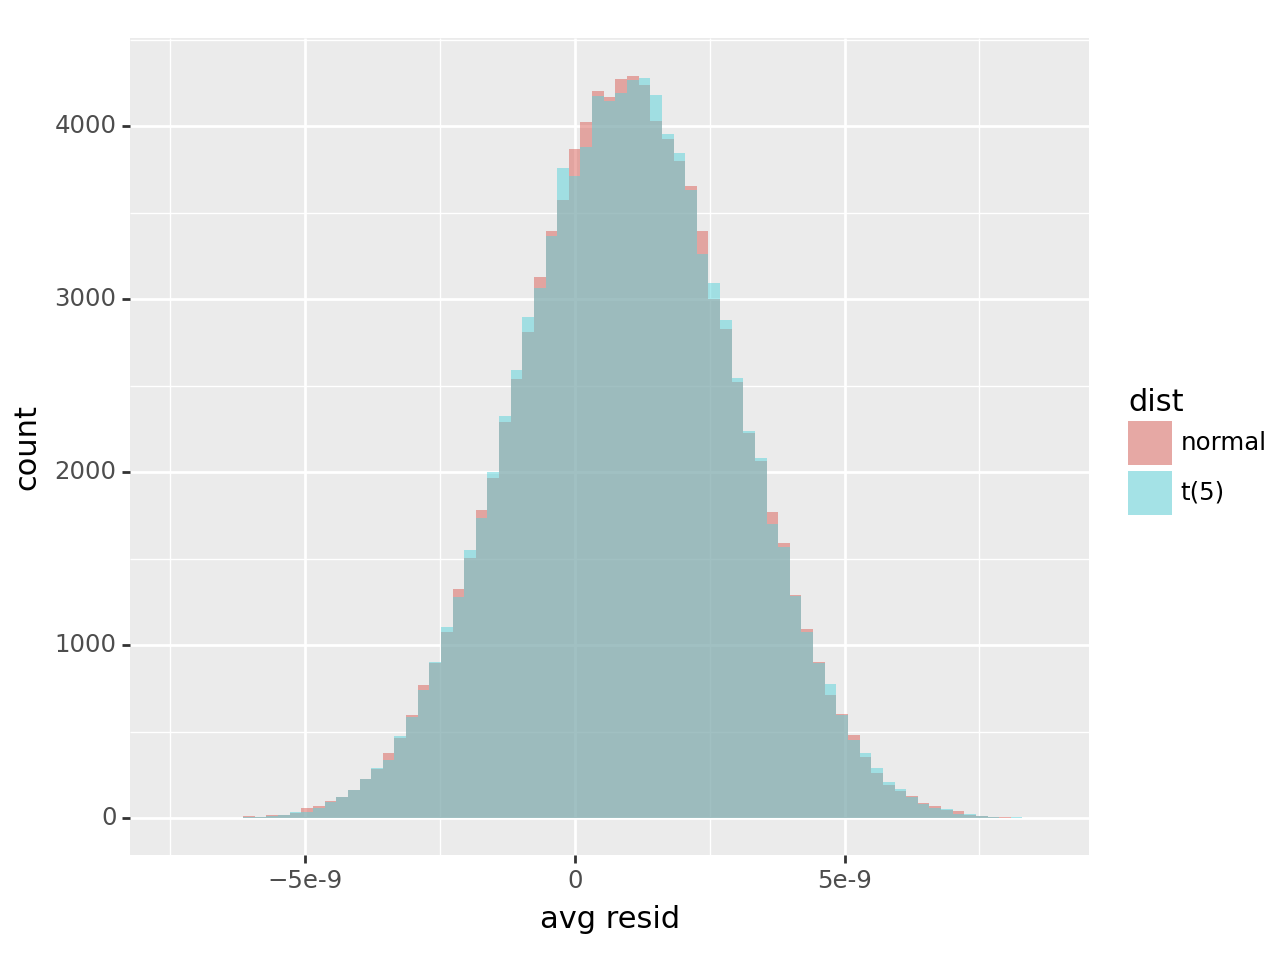

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(resid_df) +
 geom_histogram(aes(x="avg resid", fill="dist"),bins=75,
                alpha=.5 ,position="identity")
 )

Since we are working with OLS, we expect to see that the average residuals are (almost) zero.

### j

In [ ]:
print("average of R² for different distributions:")
print(r2_dist.agg(np.mean).round(4))
print("--------------------")
print("average of adjusted R² for different distributions:")
r2_adj_dist.agg(np.mean).round(4)

average of R² for different distributions:
normal    0.9913
t(5)      0.9857
t(10)     0.9892
t(20)     0.9904
t(25)     0.9906
t(100)    0.9912
dtype: float64
--------------------
average of adjusted R² for different distributions:


normal    0.9903
t(5)      0.9840
t(10)     0.9879
t(20)     0.9893
t(25)     0.9895
t(100)    0.9901
dtype: float64

## Question 2

In [ ]:
# splitting target variable into train and test
y_train, y_test = (gdp_data[:-10]["income"], gdp_data[-10:]["income"])

In [ ]:
# adding log-transformed values and creating train and test feature set
x_logs = np.log(gdp_data[["capital", "labor"]].rename(columns = \
                          {"capital": "log_K", "labor": "log_L"}))
x_full = pd.concat([gdp_data[["capital", "labor"]], x_logs], axis=1)
x_train, x_test = (x_full[:-10], x_full[-10:])

In [ ]:
m1_vars = ["log_L", "log_K"]
m2_vars = ["labor", "capital"]
m3_vars = ["log_L", "capital"]
m4_vars = ["labor", "log_K"]
vars = [m1_vars, m2_vars, m3_vars, m4_vars]

In [ ]:
# training models
M1 = sm.OLS(y_train, sm.add_constant(x_train[m1_vars])).fit()
M2 = sm.OLS(y_train, sm.add_constant(x_train[m2_vars])).fit()
M3 = sm.OLS(y_train, sm.add_constant(x_train[m3_vars])).fit()
M4 = sm.OLS(y_train, sm.add_constant(x_train[m4_vars])).fit()
models = [M1, M2, M3, M4]

In [ ]:
# obtaining MSE for train and test set
train_mse = []
test_mse = []
for (mdl, v) in zip(models, vars):
  train_mse.append(\
   (mean_squared_error(y_train, mdl.predict(sm.add_constant(x_train[v])))))
  test_mse.append(\
   (mean_squared_error(y_test, mdl.predict(sm.add_constant(x_test[v])))))
# let's create an MSE dataframe and format it
pd.DataFrame({"train mse": train_mse,
              "test mse": test_mse}, index = ["M1", "M2", "M3", "M4"])\
              .style.format("{:,.0f}")

,train mse,test mse
M1,"6,567,126","1,812,306,776"
M2,"2,468,870","92,448,940"
M3,"4,628,725","972,141,751"
M4,"3,666,765","64,919,213"


M2 is better in training sample but M4 performs better in test sample. The reason why is M2 overfits and fails on the test sample compared to M4. M1 is the worst in both samples.

## Question 3

In [ ]:
# the following function yields MSE for Leave One out Cross Validation
def loocv_mse(y,x):
  model = LinearRegression()
  scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error',
                          cv=LeaveOneOut(), n_jobs=-1)
  return scores.mean()*-1

In [ ]:
loocv_error = []
for v in vars:
  loocv_error.append(loocv_mse(gdp_data["income"], x_full[v]))

pd.DataFrame({"loocv mse": loocv_error}, index = ["M1", "M2", "M3", "M4"])\
              .style.format("{:,.0f}")

,loocv mse
M1,"104,917,601"
M2,"70,664,229"
M3,"83,962,252"
M4,"29,791,533"


Again M4 is the best model amongst alternatives. Also LOOCV significantly boosted all models performance (compared to test results not train results). In LOOCV, for every single y<sub>i</sub> value, the model is fitted by using all available data point except i<sup>th</sup> observation as training set. So there will be n models to be implement and it tends to not overestimate, therefore this method improved overall performance of the models.

## Question 4

In [ ]:
def kfold_mse(y,x,k):
  model = LinearRegression()
  cv = KFold(n_splits=k, shuffle=True, random_state=0)
  scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error',
                          cv=cv, n_jobs=-1)
  return scores.mean()*-1

In [ ]:
kfold2_error = []
kfold4_error = []
for v in vars:
  kfold2_error.append(kfold_mse(gdp_data["income"], x_full[v], 2))
  kfold4_error.append(kfold_mse(gdp_data["income"], x_full[v], 4))

pd.DataFrame({"2-fold cv mse": kfold2_error,
              "4-fold cv mse": kfold4_error}, index = ["M1", "M2", "M3", "M4"])\
              .style.format("{:,.0f}")

,2-fold cv mse,4-fold cv mse
M1,"100,878,641","85,710,186"
M2,"83,460,096","91,227,129"
M3,"94,517,916","108,271,468"
M4,"39,040,020","38,255,700"


k-fold CV is another approach to evaluate performance. Except for M1, this method did not beat LOOCV. Also, increasing the k did not help for M2 and M3. It is also important that when we divide data for cross validation, we should consider the number of observations in each fold. In this case, when k is 4, there are only 5 observation for each fold which is quite less than adequate i.e. not large enough to evaluate models' performance.

## Question 5

### a

In [ ]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x-2*x**2+rng.normal(size=100)

### b

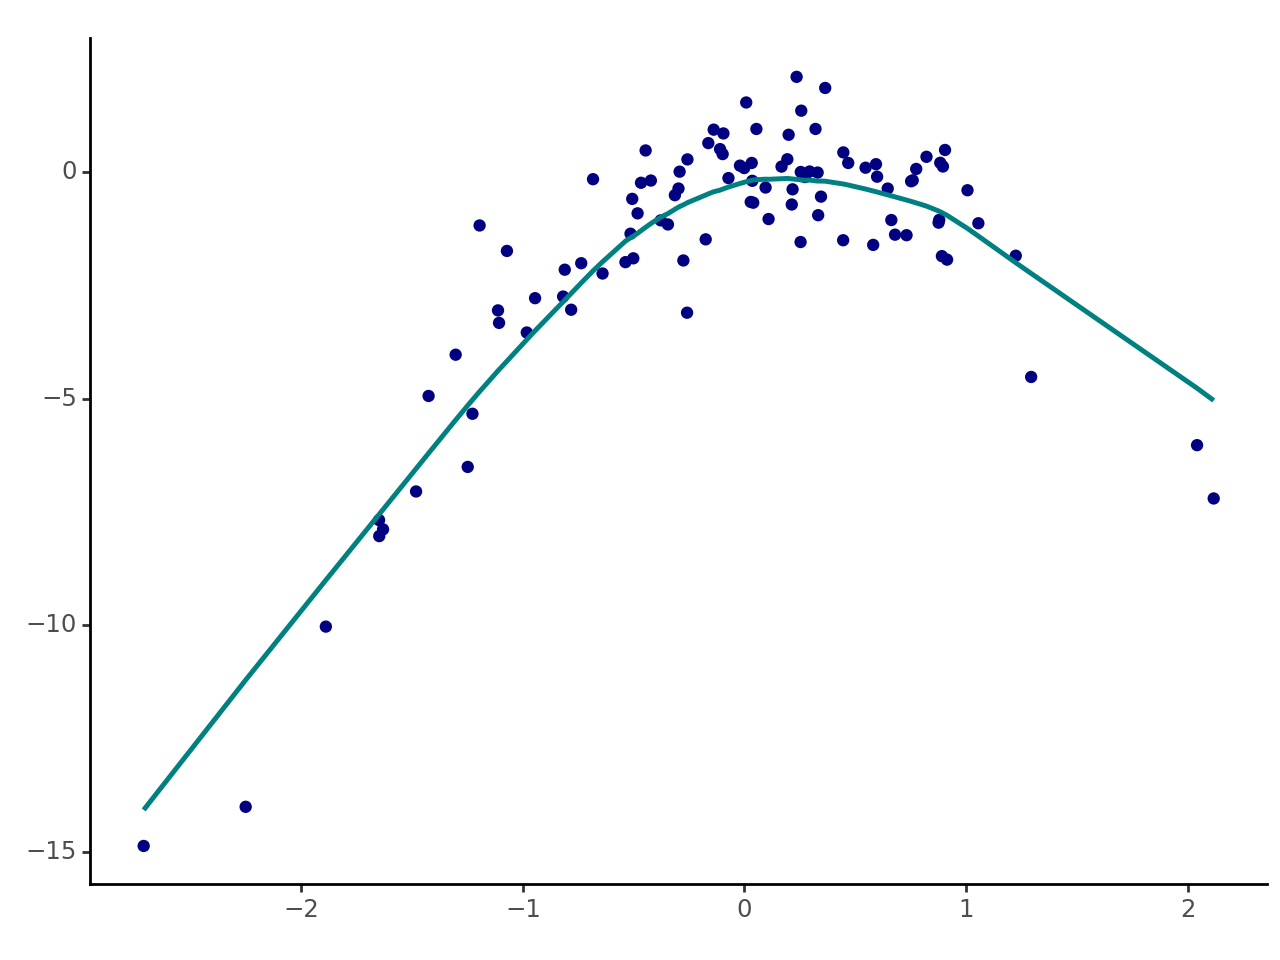

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(aes(x,y)) +
  geom_point(colour = "navy") +
  geom_smooth(colour = "teal", se=False) +
  theme_classic()
)

It's a quadratic function obviously and a linear model won't work.

### c

In [ ]:
def poly_features(x, degree):
  """
  this function creates a data frame with a constant and polynomial features
  from 1d array
  """
  col_names = ["const"]
  col_names += [f"x{deg+1}" for deg in range(degree)]
  from sklearn.preprocessing import PolynomialFeatures
  poly_feats = PolynomialFeatures(degree=degree)
  xp = pd.DataFrame(poly_feats.fit_transform(x.reshape(-1,1)))
  xp.columns = col_names
  return xp

In [ ]:
def loocv_mse(y,x):
  model = LinearRegression()
  cv = LeaveOneOut()
  scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error',
                          cv=cv, n_jobs=-1)
  return scores.mean()*-1

In [ ]:
np.random.seed(1)
degree = 4  # max degree
for deg in range(1,degree+1):
  print(f"mse for degree {deg}:\t {loocv_mse(y,poly_features(x, deg))}")

mse for degree 1:	 6.633029839181984
mse for degree 2:	 1.122936856341969
mse for degree 3:	 1.3017965489358863
mse for degree 4:	 1.3323942694179336


As expected, quadratic function fits best. Indeed we created a quadratic function and test it with different degrees.

### d

In [ ]:
np.random.seed(2)
degree = 4
for deg in range(1,degree+1):
  print(f"MSE for degree {deg}:\t {loocv_mse(y,poly_features(x, deg))}")

MSE for degree 1:	 6.633029839181984
MSE for degree 2:	 1.122936856341969
MSE for degree 3:	 1.3017965489358863
MSE for degree 4:	 1.3323942694179336


We got exactly the same output because there is no randomness in LOOCV. One advantage of this approach we use all data points, however for larger data sets it may be time consuming.

### e

Second model is the best. Of course we expected this result since y(x) is a polynomial function of degree 2, as previously mentioned.

### f

In [ ]:
xp1,xp2,xp3,xp4 = [poly_features(x,deg+1) for deg in range(degree)]

In [ ]:
model = sm.OLS(y,xp2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     379.5
Date:                Sat, 22 Jun 2024   Prob (F-statistic):           1.36e-46
Time:                        23:39:40   Log-Likelihood:                -141.06
No. Observations:                 100   AIC:                             288.1
Df Residuals:                      97   BIC:                             295.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0728      0.119     -0.611      0.543      -0.309       0.164
x1             0.9663      0.126      7.647      0.000       0.715       1.217
x2            -2.0047      0.091    -22.072      0.000      -2.185      -1.824
==============================================================================
Omnibus:                        1.338   Durbin-Watson:                   2.197
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                0.814
Skew:                           0.119   Prob(JB):                        0.666
Kurtosis:                       3.372   Cond. No.                         2.23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
round(model.pvalues,4)

const    0.5428
x1       0.0000
x2       0.0000
dtype: float64

In [ ]:
model1 = sm.OLS(y,xp1).fit()
model2 = sm.OLS(y,xp2).fit()
model3 = sm.OLS(y,xp3).fit()
model4 = sm.OLS(y,xp4).fit()

In [ ]:
print("** p values for model 1 **")
print(round(model1.pvalues,4))
print("** p values for model 2 **")
print(round(model2.pvalues,4))
print("** p values for model 3 **")
print(round(model3.pvalues,4))
print("** p values for model 4 **")
print(round(model4.pvalues,4))

** p values for model 1 **
const    0.0
x1       0.0
dtype: float64
** p values for model 2 **
const    0.5428
x1       0.0000
x2       0.0000
dtype: float64
** p values for model 3 **
const    0.6345
x1       0.0000
x2       0.0000
x3       0.2872
dtype: float64
** p values for model 4 **
const    0.4596
x1       0.0000
x2       0.0000
x3       0.6425
x4       0.0231
dtype: float64


When we define the y function, there is no intercept and there are x and x^2 values. So we expect that constant is not statistically significant. Also for higher degrees x^3 and x^4 coefficients also not significant as expected. In linear model, intercept is statistically significant but there is no need to say that this model is awful for this case.

## Question 6

In [ ]:
sat = pd.read_csv("/content/correl_pop.csv")

### a

In [ ]:
N = len(sat)  # population size
n_sample = [82, 40, 30, 20, 10, 5] # sample sizes
B = 100_000 # bootstrap rep

In [ ]:
# First, calculate correlation coef for population and store it
corr_pop = np.corrcoef(sat['GPA'], sat['SAT'])[0,1]
corr_pop

0.7584635323447978

In [ ]:
# this function might be handy
def BScorr(df, n ,B=100_000, seed=1):
  if n<=1:
    raise ValueError("pick a sample size greater than 1")
  np.random.seed(seed)
  smpl=df.sample(n)
  corr_s = np.empty(B)
  np.random.seed(seed)
  for i in range(B):
    resamp = smpl.iloc[np.random.choice(n,size=n,replace=True)]
    corr_s[i] = np.corrcoef(resamp['GPA'], resamp['SAT'])[0,1]
  return corr_s

In [ ]:
corrs=pd.DataFrame(columns=n_sample)  # an empty data frame
for n in n_sample:
  corrs[n]=BScorr(sat,n)
corrs

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide


,82,40,30,20,10,5
0,0.782349,0.776930,0.800089,0.774530,0.716841,0.529593
1,0.720394,0.836107,0.828181,0.701184,0.411395,0.155225
2,0.738040,0.694517,0.780106,0.754084,0.760338,-0.335451
3,0.796011,0.751397,0.844685,0.695039,0.703390,0.078556
4,0.720245,0.748744,0.698083,0.672326,0.895264,0.262604
...,...,...,...,...,...,...
99995,0.741407,0.765677,0.709453,0.706265,0.376365,0.465834
99996,0.764106,0.864595,0.821770,0.832121,0.802363,-0.280056
99997,0.706081,0.779609,0.765290,0.719144,0.706115,0.156015
99998,0.801032,0.783602,0.613184,0.783840,0.767267,0.990255


In [ ]:
corrs.agg(np.mean)

82    0.755786
40    0.775102
30    0.793250
20    0.737599
10    0.665540
5     0.090790
dtype: float64

n=40 is quite close to the correlation coefficient of population. 30 and 20 are close to the this level but 10 and 5 are clearly far from ideal.

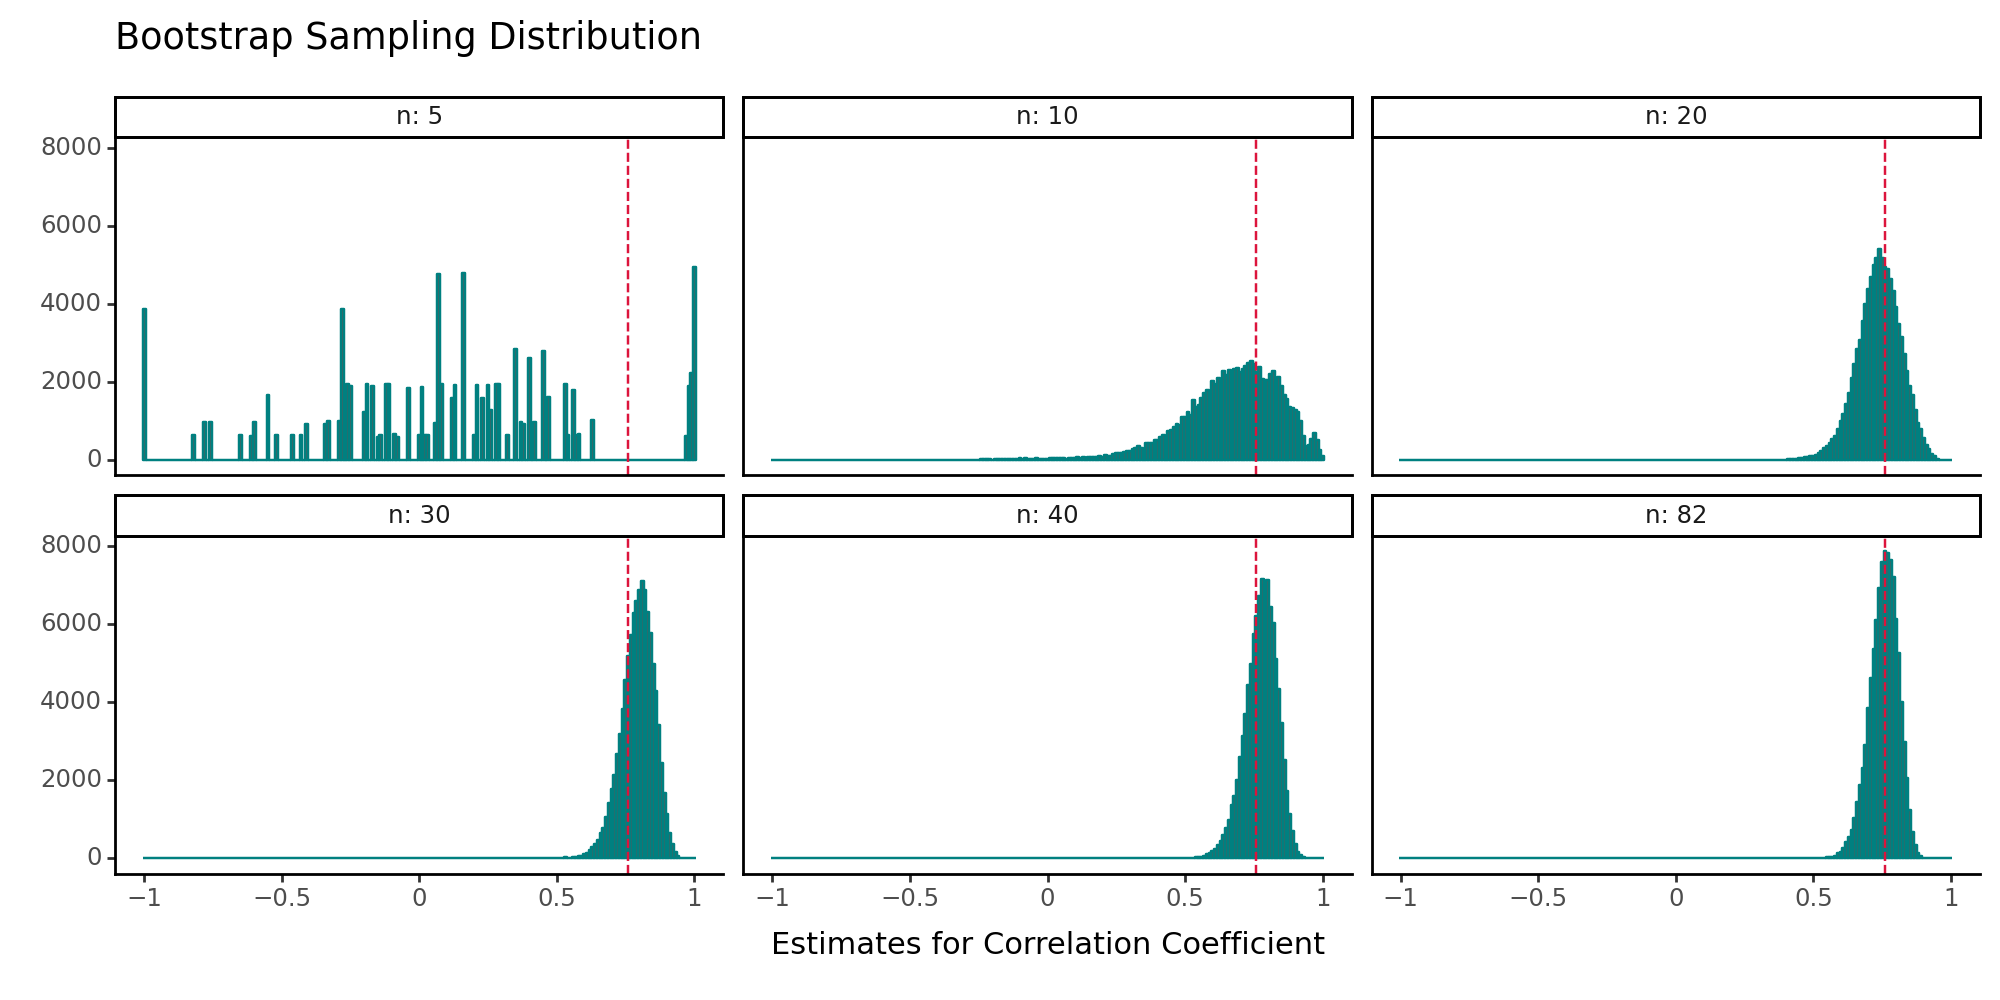

<Figure Size: (1000 x 500)>

In [ ]:
corrs_melt = corrs.melt(var_name="n", value_name="corr")
corrs_melt["n"] = corrs_melt["n"].astype("category")

(ggplot(corrs_melt.dropna(), aes(x="corr")) +
 geom_histogram(position="identity", color="teal", binwidth=.01) +
 facet_wrap("n", ncol=3, labeller=label_both) +
 theme_classic() +
 theme(figure_size=(10, 5)) +
 geom_vline(xintercept=corr_pop, linetype="dashed", color ="crimson") +
 labs(title="Bootstrap Sampling Distribution",x="Estimates for Correlation Coefficient", y="")
)

### b

Sample size of 5 returns inaccurate estimates for correlation coefficient; and not even a single run out of 100,000 simulations couldn't make an estimation close to the (true) population correlation which is approximately 0.75. n=10 is better but the shape of the distribution is not promising (and still inaccurate). n=20 is OK, though it has fatter tail. 30 and 40 are quite adequate numbers for bootstrapping sample. Their distribution is quite similar when n equals to the population size(82), but their average slightly shifted from the true correlation coefficient.

### c

In [ ]:
percentiles = [1,5,10,90,95,99]
quant_table=pd.DataFrame(columns=[f"{p}%" for p in percentiles])
for n in n_sample:
  quant_table.loc[f"N={n}"]=np.percentile(corrs[n].dropna(),percentiles).round(4)
quant_table

,1%,5%,10%,90%,95%,99%
N=82,0.6207,0.6654,0.6883,0.8185,0.8332,0.8580
N=40,0.6179,0.6724,0.6990,0.8455,0.8615,0.8894
N=30,0.6324,0.6895,0.7160,0.8649,0.8806,0.9085
N=20,0.5259,0.6027,0.6369,0.8367,0.8620,0.9045
N=10,0.0333,0.3423,0.4412,0.8731,0.9104,0.9729
N=5,-1.0000,-0.7775,-0.5495,0.6350,1.0000,1.0000


The lower and upper first percentile for n=5 is -1 and 1 respectively. Indeed, this is not an estimation since correlation coefficient is between -1 and 1 by its definition. n=10 just says that there's a positive correlation (confidence interval is too wide). As n getting closer to the population size, the confidence intervals are getting narrower (more precise estimations) and all confidence interval contains the true value of correlation coefficient.

### d - e

In [ ]:
corr_15 = BScorr(sat, 15)
ci_lo, ci_up = np.percentile(corr_15, [2.5, 97.5]).round(4)

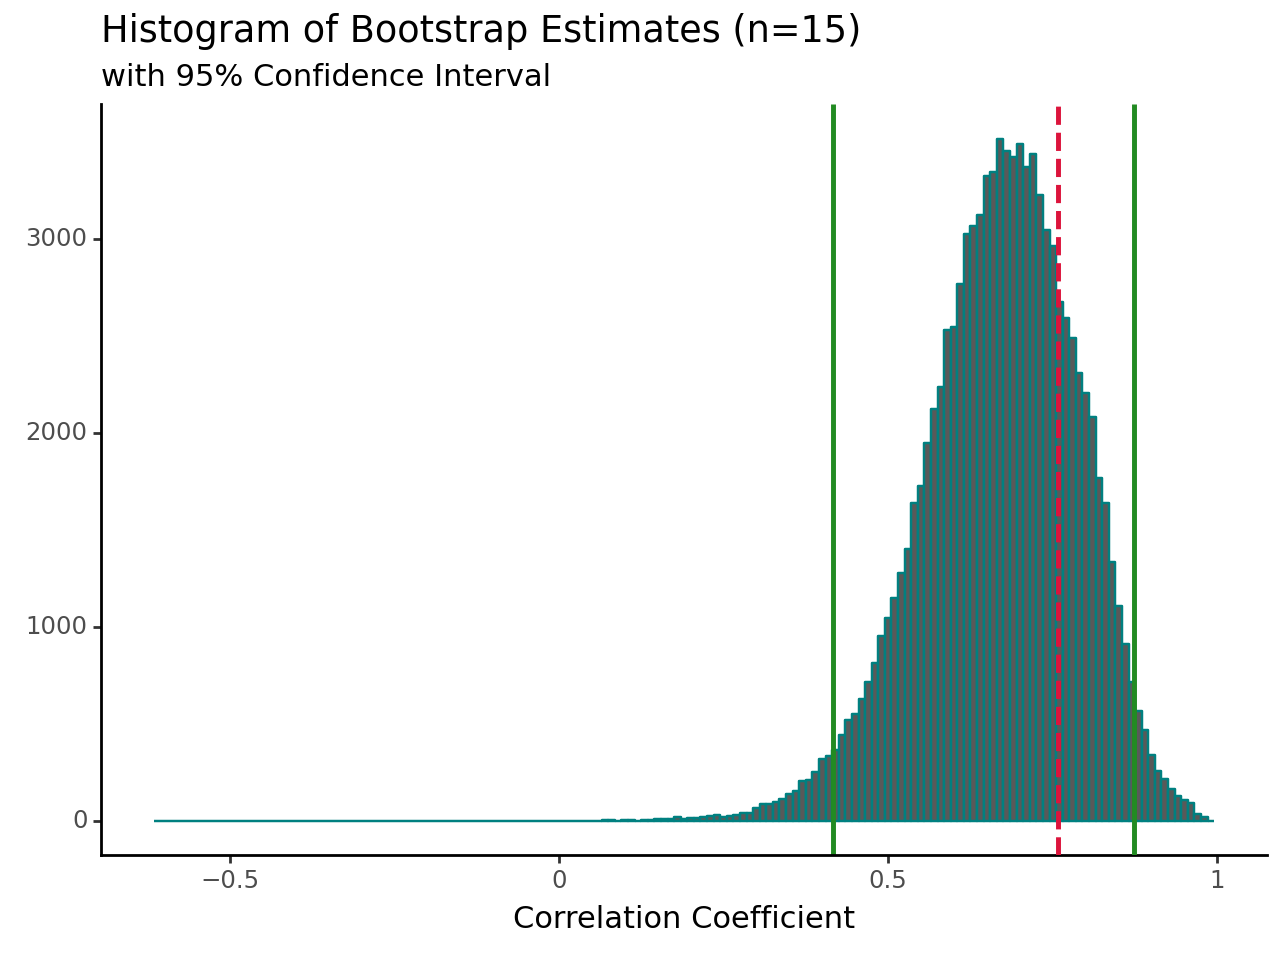

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(aes(x=corr_15)) +
 geom_histogram(position="identity", color="teal", binwidth=.01) +
 theme_classic() +
 geom_vline(xintercept=ci_lo, color ="forestgreen", size=1) +
 geom_vline(xintercept=ci_up, color ="forestgreen", size=1) +
 geom_vline(xintercept=corr_pop, linetype="dashed", color ="crimson", size=1) +
 labs(title="Histogram of Bootstrap Estimates (n=15)",
      subtitle="with 95% Confidence Interval",x="Correlation Coefficient", y="")
)

## Question 7

### a - b

In [ ]:
# Student's t-distribution with 3 degrees of freedom
def t_distribution(n):
  return np.random.standard_t(3, n)

# F-distribution with 4 degrees of freedom in numerator and 6 degrees of freedom in denominator
def f_distribution(n):
  return np.random.f(4,6,n)

# Sample sizes and number of samples
sample_sizes = [5, 10, 100, 500, 1000, 2000, 5000, 10000]
num_samples = 1000

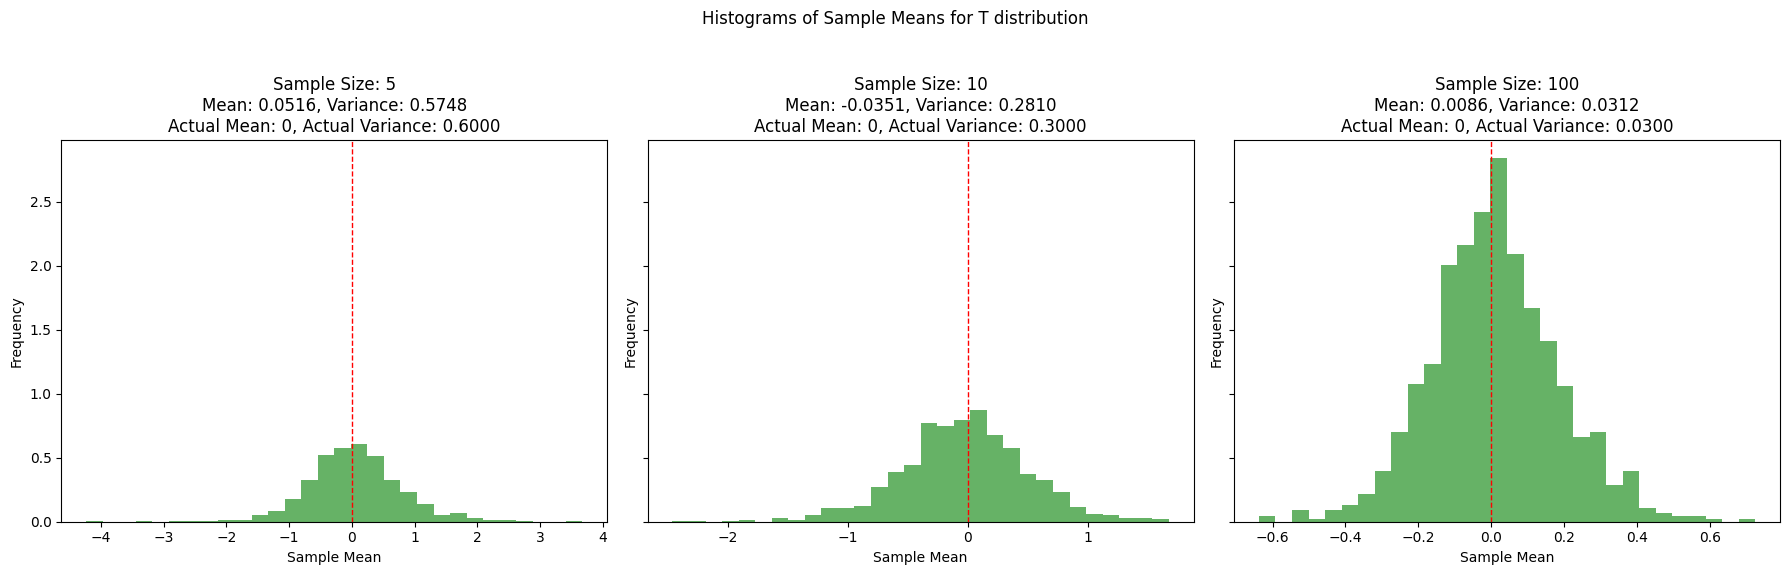

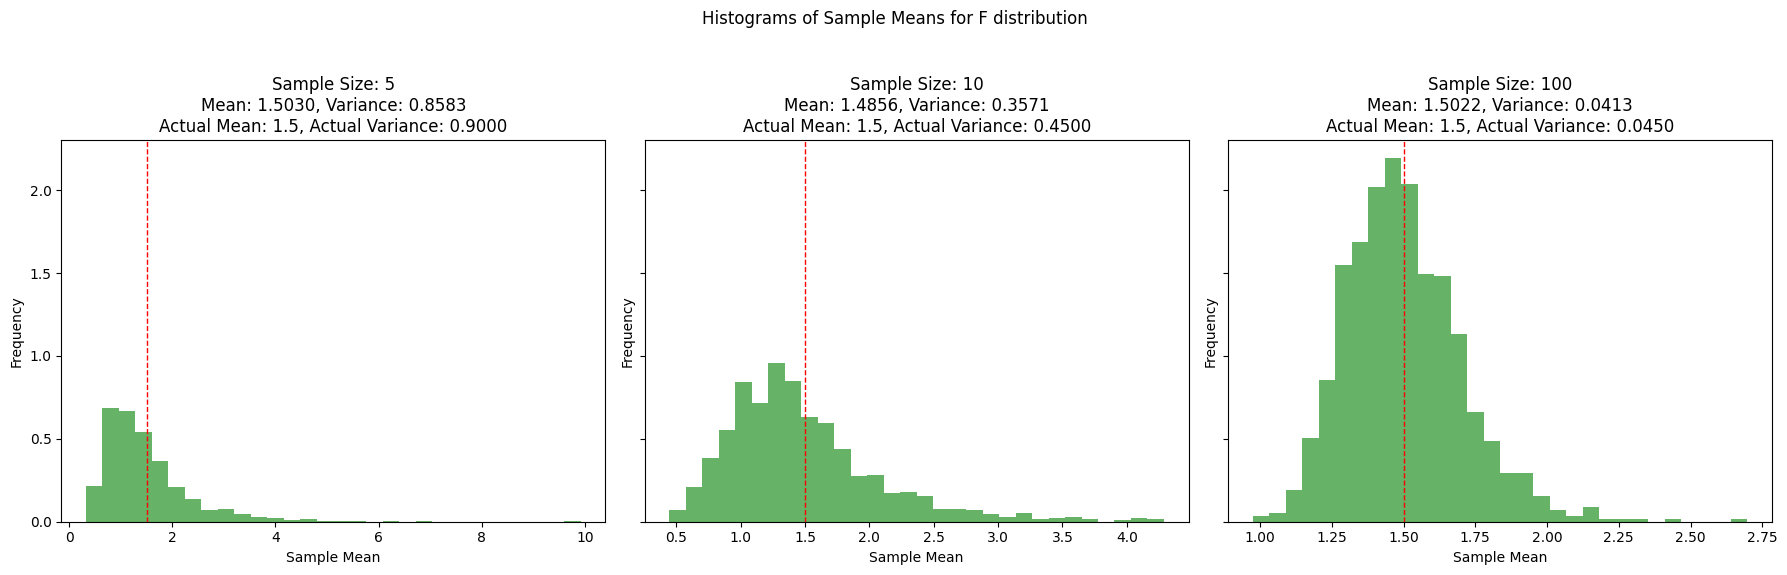

In [ ]:
# Function to generate sample stats
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
  sample_means = {}
  sample_variances = {}
  for n in sample_sizes:
      means = []
      variances = []
      for _ in range(num_samples):
          sample = distribution_func(n)
          means.append(np.mean(sample))
          variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
      sample_means[n] = means
      # Correct variance calculation: Variance of the means, not means of variances
      sample_variances[n] = np.var(means, ddof=1)
  return sample_means, sample_variances

# Main distribution parameters
main_distribution = {
    "T": {"mean": 0, "variance": 3},
    "F": {"mean": 1.5, "variance": 4.5}
}


# Generate sample means and variances for each distribution
for distribution_name, params in main_distribution.items():
  distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
  actual_mean = params["mean"]
  actual_variance = params["variance"]

  sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

  # Plotting histograms for the means of sample sizes 10, 100, 1000
  fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
  fig.suptitle(f"Histograms of Sample Means for {distribution_name} distribution")

  for ax, (n, means) in zip(axs, sample_means.items()):
      ax.hist(means, bins=30, density=True, alpha=0.6, color='g')
      ax.axvline(actual_mean, color='r', linestyle='dashed', linewidth=1)
      ax.set_title(f'Sample Size: {n}\nMean: {np.mean(means):.4f}, Variance: {np.var(means, ddof=1):.4f}\nActual Mean: {actual_mean}, Actual Variance: {actual_variance / n:.4f}')
      ax.set_xlabel('Sample Mean')
      ax.set_ylabel('Frequency')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

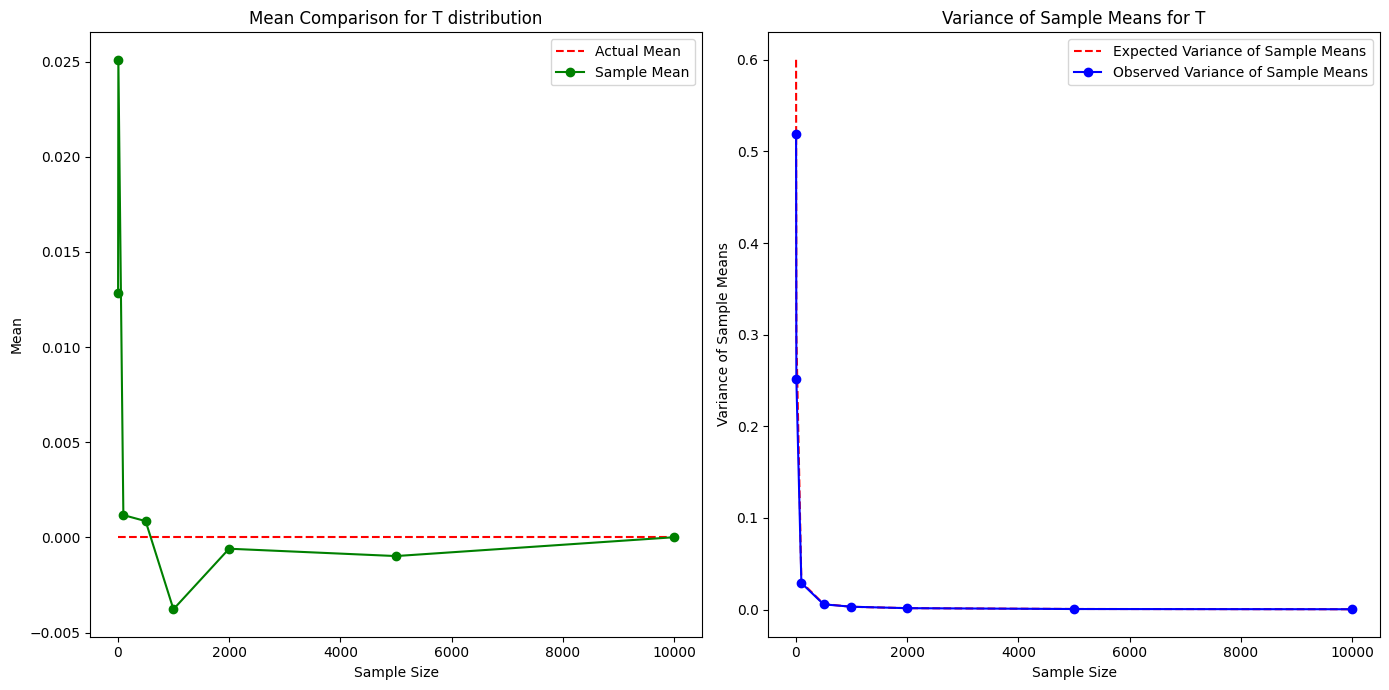

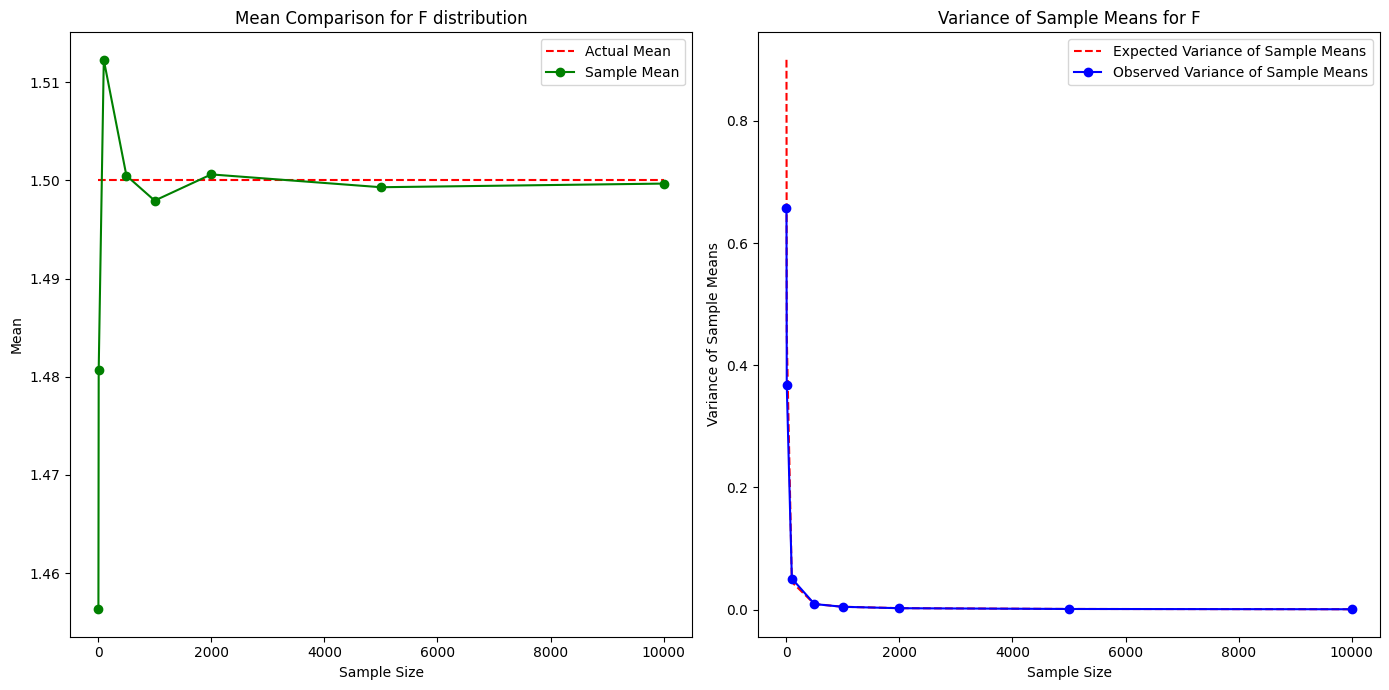

In [ ]:
def generate_sample_stats2(distribution_func, sample_sizes, num_samples):
    sample_means = []
    sample_variances = []
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means.append(np.mean(means))
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances.append(np.var(means, ddof=1))
    return sample_means, sample_variances

  # Generate sample means and variances for each distribution, and plot the results
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats2(distribution_func, sample_sizes, num_samples)

    # Plotting Mean and Variance changes
    plt.figure(figsize=(14, 7))

    # Plot for Means
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, [actual_mean] * len(sample_sizes), 'r--', label='Actual Mean')
    plt.plot(sample_sizes, sample_means, 'g-o', label='Sample Mean')
    plt.xlabel('Sample Size')
    plt.ylabel('Mean')
    plt.title(f'Mean Comparison for {distribution_name} distribution')
    plt.legend()

    # Plot for Variance of Sample Means
    plt.subplot(1, 2, 2)
    expected_variance = [actual_variance / n for n in sample_sizes]  # Expected decrease as per CLT
    plt.plot(sample_sizes, expected_variance, 'r--', label='Expected Variance of Sample Means')
    plt.plot(sample_sizes, sample_variances, 'b-o', label='Observed Variance of Sample Means')
    plt.xlabel('Sample Size')
    plt.ylabel('Variance of Sample Means')
    plt.title(f'Variance of Sample Means for {distribution_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()